<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/ml/torch/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch で MNIST

[公式サンプル](https://github.com/pytorch/examples/blob/main/mnist/main.py)をベースに実装

## 事前確認

バージョンチェック

In [1]:
import torch

print(f"torch.__version__={torch.__version__}")
print(f"torch.cuda.is_available()={torch.cuda.is_available()}\n")

print(f"torch.cuda.device_count()={torch.cuda.is_available()}")
print(f"torch.cuda.current_device()={torch.cuda.is_available()}")
print(f"torch.cuda.device(0)={torch.cuda.device(0)}\n")

if torch.cuda.is_available():
    print(f"torch.cuda.get_device_name(0)={torch.cuda.get_device_name(0)}")
    print(f"torch.cuda.get_device_capability()={torch.cuda.get_device_capability()}")

torch.__version__=2.1.0+cu118
torch.cuda.is_available()=True

torch.cuda.device_count()=True
torch.cuda.current_device()=True
torch.cuda.device(0)=<torch.cuda.device object at 0x79ae89959120>

torch.cuda.get_device_name(0)=Tesla T4
torch.cuda.get_device_capability()=(7, 5)


seed の固定。deterministic は処理低下を起こすため注意。

In [2]:
import random
import numpy as np

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms = True


torch_fix_seed()

Tensorboard の用意

In [3]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

## データセットの用意

データの読み込み

In [4]:
%%capture
from torchvision import datasets, transforms

mean, scale = 0.1307, 0.3081
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (scale,))
])
dataset1 = datasets.MNIST(
    '../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(
    '../data', train=False, transform=transform)

データの可視化

answer=5


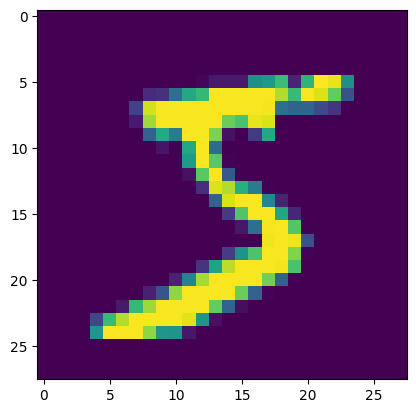

In [5]:
import matplotlib.pyplot as plt

dataset1_data = dataset1.data.numpy()
dataset1_targets = dataset1.targets.numpy()

print(f"answer={dataset1_targets[0]}")
img = dataset1_data[0]
plt.imshow(img)

データローダの作成。
[高速化のためのオプション](https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587)を設定。

In [6]:
cuda_kwargs = {
    'num_workers': 2,
    'pin_memory': True,
    'shuffle': True
}

train_batch_size, test_batch_size = 64, 1000
train_kwargs = {'batch_size': train_batch_size}
test_kwargs = {'batch_size': test_batch_size}

train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

## モデル作成

モデル定義

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

モデルのインスタンスを作成

In [8]:
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Use device={device_str}")
device = torch.device(device_str)

model = Net().to(device)

Use device=cuda


単一データで推論する関数を定義。推論前に `model.eval()` が必要なことに注意。

In [9]:
def single_inference(model, idx):
    # slice only 1 data
    img = dataset1.data[[idx], ...].to(device)
    # add channel axis (size 1)
    img = img[:, None, ...]
    # normalization
    img = (img - mean) / scale

    print(f"input data shape = {img.shape}")

    # use inference mode
    # (otherwise 32 batch size needed)
    model.eval()
    with torch.no_grad():
        probs = model(img)

    # get highest probability
    inference = probs.argmax(dim=1, keepdim=True)[0, 0]
    answer = dataset1.targets[idx]

    print(f"inference={inference}")
    print(f"answer={answer}")

実際に推論。未学習なので不正解。

In [10]:
single_inference(model, idx=0)

input data shape = torch.Size([1, 1, 28, 28])
inference=0
answer=5


## 学習

最適化手法を定義

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

lr = 1.0
gamma = 0.7
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

学習方法を定義

In [12]:
log_interval = 10
dry_run = False
amp_dtype = torch.float16 if device_str == "cuda" else torch.bfloat16

def train(model, device, train_loader, optimizer, epoch):
    model.train()

    # AMP: Automatic Mixed Precision
    scaler = torch.cuda.amp.GradScaler()

    for batch_idx, (data, target) in enumerate(train_loader):
        # data transfer
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # AMP: Automatic Mixed Precision
        with torch.amp.autocast(device_str, dtype=amp_dtype):
            # inference
            output = model(data)
            # nll = negative log likelihood loss
            loss = F.nll_loss(output, target)

        writer.add_scalar("Loss/train", loss, epoch)

        # back propagation
        scaler.scale(loss).backward()
        # gradient decent
        scaler.step(optimizer)
        # update scale
        scaler.update()

#        if batch_idx % log_interval != 0:
#            continue

#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#            epoch, batch_idx * len(data), len(train_loader.dataset),
#            100. * batch_idx / len(train_loader), loss.item()))

#        if dry_run:
#            break

推論・バリデーション

In [13]:
def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.3f}%)")

学習を実行

In [14]:
from tqdm import tqdm

epochs = 14
for epoch in tqdm(range(1, epochs + 1)):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

writer.flush()

100%|██████████| 14/14 [04:24<00:00, 18.90s/it]


Tensorboard の起動。
Chrome との相性が悪いため [Tips](https://github.com/googlecolab/colabtools/issues/3990#issuecomment-1782676249) を利用。

In [15]:
%%capture

%load_ext tensorboard
# Start tensorboard
# Please ignore the error page in the output and go to the next cell
%tensorboard --logdir ./logs --host=127.0.0.1 --port=6006 --load_fast=false

外部リンクから Tensorboard にアクセス

In [16]:
# Access tensorboard via colab's proxy
# Click the link that appears in the output
from google.colab import output
output.serve_kernel_port_as_window(6006, path="")

<IPython.core.display.Javascript object>

モデルの保存。対象は元のモデル。

In [17]:
torch.save(model.state_dict(), "mnist_cnn.pth")

## 推論

保存したモデルのロード

In [18]:
model = Net().to(device)
model.load_state_dict(torch.load('mnist_cnn.pth'))

<All keys matched successfully>

推論を実施

In [20]:
single_inference(model, idx=0)

input data shape = torch.Size([1, 1, 28, 28])
inference=5
answer=5
